This code has been modified by Dr. Md Tanvir Arafin - mdtanvir.arafin@morgan.edu, & Jose Dominguez - jodom4@morgan.edu

In [ ]:
from datetime import datetime
import pytz

StartTime= datetime.now(pytz.timezone('America/New_York') )
current_time = StartTime.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 12:13:59


In [ ]:
# MNIST experiment from scratch
!pip install nengo
!pip install numpy
!pip install sklearn
!pip install  matplotlib

In [ ]:
import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import response_curves, tuning_curves
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#fetch data
mnist = sklearn.datasets.fetch_openml('mnist_784')

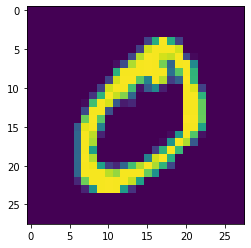

In [ ]:
#DEBUG (view data)
sample = 1
image = mnist['data'][sample]
image = image.reshape(28,28)

# plot the sample
plt.imshow(image)
plt.show()

In [ ]:
## data preprocessing
x = mnist['data'].astype(float)-128
x = x/np.linalg.norm(x, axis=1)[:,None]

In [ ]:
y = mnist['target']
y = np.eye(10)[y.astype(int)]*2-1
y = y/np.linalg.norm(y, axis=1)[:,None]

order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]  

In [ ]:
#parameters

n_training=500   #number of training images
n_testing=100    #number of testing images

n_neurons=500   #number of neurons
synapse=0.02
t_image=0.5     #time per image
dt = 0.001

X: 
 69500
784


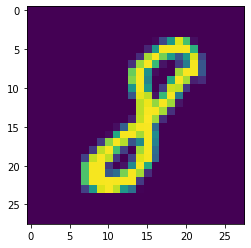

Y: 
 69500
10
[-0.31622777 -0.31622777 -0.31622777 -0.31622777 -0.31622777  0.31622777
 -0.31622777 -0.31622777 -0.31622777 -0.31622777]


In [ ]:
#DEBUG
ata=x[n_training:]
print('X: \n',len(ata))
print(len(x[50000]))
plt.imshow(x[50000].reshape(28,28))
plt.show()

rrect=y[n_training:]
print('Y: \n',len(rrect))
print(len(y[50000]))
print(y[1000])

In [ ]:
## Nengo Network 

model = nengo.Network()
with model:
    #input image made up of 784 components (used for testing)
    def stim_func(t, data=x[n_training:]):
        index = int(t / t_image)
        return data[index % len(data)]

    #this is the expected output for a given image (values from 0-9) (used for testing)
    def result_func(t, raw, correct=y[n_training:]):
                index = int((t-dt) / t_image)
                c = np.argmax(correct[index])
                r = np.argmax(raw)
                return np.hstack([raw, c, r])
    
    
    stim = nengo.Node(stim_func)
   
   #only the Ensemble is for training
    ens = nengo.Ensemble(n_neurons = n_neurons, 
                         dimensions=784,
                         intercepts=nengo.dists.CosineSimilarity(784+2)) #need clarification on the intercept used!!!
    
    result = nengo.Node(result_func, size_in=10)
    nengo.Connection(stim, ens, synapse=None)
    #This line is for training
    nengo.Connection(ens, 
                         result, 
                         eval_points=x[:n_training], 
                         function=y[:n_training],
                         solver=nengo.solvers.LstsqL2(reg=0.1),
                         synapse=synapse)
    
    output = nengo.Probe(result)
    A_spikes = nengo.Probe(ens.neurons)  # Collect the spikes

In [ ]:
with nengo.Simulator(model) as sim:  # Create the simulator
    T = n_testing * t_image #calculate total simulation time
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'x along preferred direction')

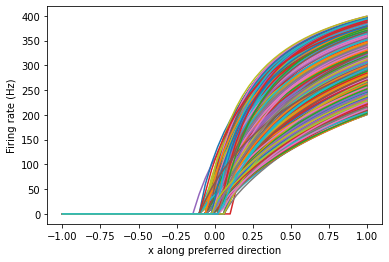

In [ ]:
#RESPONCE curves
plt.figure()
plt.plot(*response_curves(ens, sim))
plt.ylabel("Firing rate (Hz)")
plt.xlabel("x along preferred direction")

Text(0, 0.5, 'Neuron')

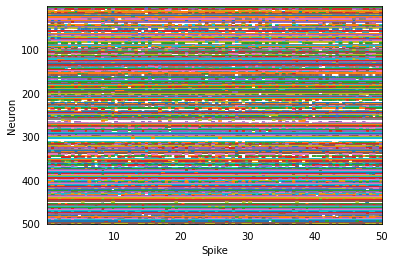

In [ ]:
#Neurons ACTIVITY
plt.figure()
rasterplot(sim.trange(), sim.data[A_spikes])
plt.xlabel('Spike')
plt.ylabel('Neuron')
#rasterplot(sim.data[A_spikes])

Accuracy: 0.71


"\nplt.plot(sim.trange(), sim.data[output][:,10:])\nplt.legend(['Target', 'Output'], loc='best')\nplt.xlabel('time(s)', fontsize=20)\nplt.ylabel('output', fontsize=20)\nplt.xlim(0, t_image * min(n_testing, 20))\n"

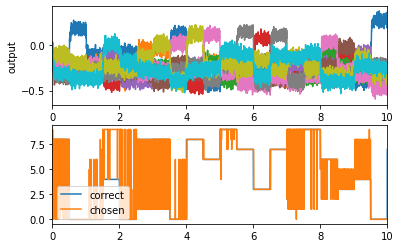

In [ ]:
correct = sim.data[output][:,10].astype(int)
result = sim.data[output][:,11].astype(int)

confusion = np.zeros((10,10), dtype=int)
count = np.zeros(10, dtype=int)

times = sim.trange()

#Calculate the training error
for i in range(n_testing):
    t = (i + 1) * t_image
    index = np.argmax(times >= t) - 1
    count[correct[index]] += 1
    confusion[correct[index],result[index]] += 1
score = sum(confusion[i, i] for i in range(10)) / float(n_testing)
print("Accuracy:",score)

#Plot results
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[output][:,:10])
plt.xlim(0, t_image * min(n_testing, 20))
plt.ylabel('output')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[output][:,10:])
plt.legend(['correct', 'chosen'], loc='best')
plt.xlim(0, t_image * min(n_testing, 20))
'''
plt.plot(sim.trange(), sim.data[output][:,10:])
plt.legend(['Target', 'Output'], loc='best')
plt.xlabel('time(s)', fontsize=20)
plt.ylabel('output', fontsize=20)
plt.xlim(0, t_image * min(n_testing, 20))
'''

In [ ]:
#Record total time to run the whole simulation
EndTime = datetime.now(pytz.timezone('America/New_York'))
TotalSimTime = EndTime - StartTime
print("Overall Sim TIme=", TotalSimTime)
#Time Format H:M:S

Overall Sim TIme= 0:01:08.169813
